### Libaries used

In [1]:
from sklearn.model_selection import train_test_split
import sklearn
import numpy as np
from torch.utils import data as T
import torch
from torchsummary import summary
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

### Data import
I will be using yacht hydrodynamics data from UCI dataset whose link can be find at the end of paragraph. 
The data focuses on prediction of residuary resistance of sailing yachts at the initial design stage is of a great value for evaluating the ships performance and for estimating the required propulsive power. Essential inputs include the basic hull dimensions and the boat velocity.

The Delft data set comprises 308 full-scale experiments, which were performed at the Delft Ship Hydromechanics Laboratory for that purpose. These experiments include 22 different hull forms, derived from a parent form closely related to the designed by Frans Maas.

https://archive.ics.uci.edu/ml/datasets/Yacht+Hydrodynamics

In [2]:
data = pd.read_csv("yacht_hydrodynamics.data",sep = " ",
                   names = ["Long Position","Prismatic coefficient","length-displacement ratio",
                            "bean-draught ratio","length-bean ratio","froude number","residuary resistance"])
data = data.fillna(0)

In [3]:
data.head()

,Long Position,Prismatic coefficient,length-displacement ratio,bean-draught ratio,length-bean ratio,froude number,residuary resistance
0,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
1,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
2,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
3,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
4,-2.3,0.568,4.78,3.99,3.17,0.225,1.18


#### Making two different objects one which holders all the features and other which holds our target or dependent variable.
We have used minmax scaler on the our target variable so that we will have same range with the predicted data from the model and our y. We will be converting all the data into the tensor.

In [4]:
features = torch.tensor(data[["Long Position","Prismatic coefficient","length-displacement ratio",
                            "bean-draught ratio","length-bean ratio","froude number"]].values)
target = sklearn.preprocessing.minmax_scale(data[["residuary resistance"]], feature_range=(0, 1), axis=0, copy=True)
target = torch.tensor(target)

#### Calling train test split function of the scikit-learn to divide the data into two parts where 80% of the data lies in training and rest 20% in the testing.

In [5]:
train_features,test_features,train_target,test_target= train_test_split(features, target, test_size = 0.2,random_state=100)

### Making a dataloader object
For making a dataloader object, we will first create a dataset class which uses the superclass from torce.utils.data. We will use below class to make a object of dataset class and will use this object to create a object of dataloader.

In [6]:
class DatasetT(T.Dataset):
   
    def __init__(self, features,labels):
        'Initialization'
        self.X = features
        self.Y = labels

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)
   
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        x = self.X[index]
        y = self.Y[index]

        return x,y

In [7]:
trainset = DatasetT(train_features,train_target)
testset = DatasetT(test_features,test_target)

#### Making Dataloader object with batchsize as the number of instances in dataset

In [8]:
train_loader = torch.utils.data.DataLoader(dataset=trainset, 
                                           batch_size=277, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=testset, 
                                           batch_size=62, 
                                           shuffle=True)

### Model class
Below is the network with one input layer, one output layer and one hidden layer. Our input layer has 6 neurons which is equal to the number of features in our dataset. Hidden layer consists of 2d dimensions which is 12 input neurons and one output neuron for output. We have sigmoid activation as directed in the assignment document

In [9]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(6, 12)
        self.fc2 = nn.Linear(12, 1)

    def forward(self,x):
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

### Creating model object

In [10]:
model = Network()

### Loss function and optimizer
We have used MSE as the loss function and adam optimizer with learning rate as 0.005

In [11]:
from torch.optim import Adam
from sklearn.metrics import mean_squared_error, r2_score

criterion = nn.MSELoss()
optm = Adam(model.parameters(), lr = 0.0003)

### Training the model with 200 epoch and storing all the mse in a list

In [12]:
train_mse = []
test_mse = []
for epoch in range(500):
    yPred = []
    yA = []
    for i, (x, y) in enumerate(train_loader):
        optm.zero_grad()                   
        outputs = model(x.float())                        
        loss = criterion(outputs, y.float())            
        loss.backward()                         
        optm.step() 
        yPred.append(outputs)
        yA.append(y)
    train_mse.append(mean_squared_error(yA[0].detach().numpy(), yPred[0].detach().numpy()))
    yPred = []
    yA = []
    with torch.no_grad():
        for x,y in test_loader:
            output = model(x.float()) 
            yPred.append(output)
            yA.append(y)
    test_mse.append(mean_squared_error(yA[0].detach().numpy(), yPred[0].detach().numpy()))

### Building plot for training data
Since we have specified the batch size as the number of instances in the dataset so the weight update will be 1 in each epoch. So our x-axis will be the number of epochs and on the y axis will be the mse.

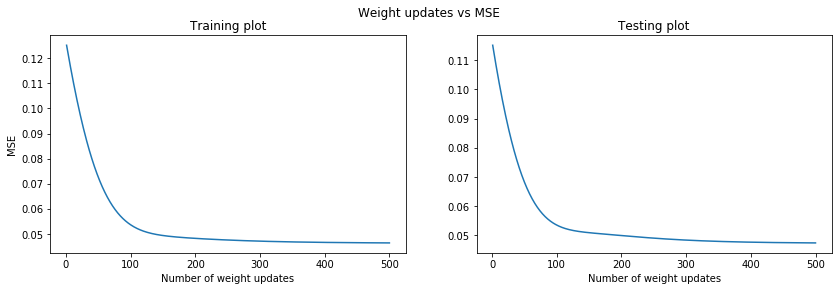

In [13]:
xaxis = range(1,501)
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14, 4))
fig.suptitle('Weight updates vs MSE')

ax1.plot(xaxis,train_mse)
ax1.title.set_text('Training plot')
ax1.set_xlabel('Number of weight updates')

ax2.plot(xaxis,test_mse)
ax2.title.set_text('Testing plot')
ax2.set_xlabel('Number of weight updates')

ax1.set_ylabel('MSE');